# TomoTwin: A simple digital twin for synchrotron micro-CT  

## Polydisperse spheres / micro-CT  

### Author: Aniket Tekawade  

1. Phantom mimicking glass spheres dataset using Porespy (Label 0 is spherical void, label 1 is silica)  
2. model attenuation / noise with Poisson assumption and data from XOP  
3. model phase-contrast with inverse phase-retrieval step (assuming refractive index is proportional to absorption coefficient  
4. model beam profile with XOP data on bending magnet power distribution at 35 m from source


Important Information: Data from this notebook has not been published yet. Please contact the author if you intend on using it.  

In [1]:
data_for = "train_"
sample_tag = "spheres"
energy_pts = 30.0 # keV
detector_dist = 6.0 # cm
rad = 14
sample_tag = data_for + sample_tag + "_%ikeV_%imm_%irad"%(energy_pts, 10.0*detector_dist, rad)
print("sample_tag = %s"%sample_tag)


# sample_tag = "spheres_att"
# energy_pts = 27.4 # keV
# detector_dist = 2.5 # cm

# sample_tag = "spheres_pcmode"
# energy_pts = 27.4 # keV
# detector_dist = 10.0 # cm

sample_tag = train_spheres_30keV_60mm_14rad


### Acquisition parameters  

In [2]:
noise = 1.0 # multiplier to noise std. dev. 1.0 is perfect Poisson dist.
blur_size = 5 # blur kernel

# Select the FOV  
FOV = (400,512) # Vertical, Horizontal in nrows, ncols
res = 0.7
n_projections = 501
theta = (0,180,n_projections)

In [3]:
%matplotlib inline
# pip package imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ct_segnet.data_utils.data_io import DataFile
from ct_segnet import viewer
import time
import os

from porespy import generators
# local imports
tomo_twin_path = "/data02/MyArchive/TomoTwin/tomo_twin"
if tomo_twin_path not in sys.path: # local imports
    sys.path.append(tomo_twin_path)
import ray_utils as ray
from utils import *
source_file_path = '/data02/MyArchive/TomoTwin/model_data/source_files/7BM/beam_profile_7BM.hdf5'
material_data_path = '/data02/MyArchive/TomoTwin/model_data'

# import ipywidgets.interact class, this class will represent a slide bar.
from ipywidgets import interact
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
from IPython.display import display
figw = 12

### Make 'beam' or 'flat-field' array  
Intensity profile of a bending magnet beam at APS. It is assumed that the camera is well-centered on the vertical center ofthe fan beam. Beam energy also affects the beam intensity profile.  

In [4]:
print("FOV of %.1f mm high, %.1f mm wide; pixel size %.2f um"%(FOV[0]*res/1000, FOV[1]*res/1000, res))
proj_shape = FOV
obj_shape = (proj_shape[0], proj_shape[1], proj_shape[1])
print("Shape of the projection image: %s"%str(proj_shape))

FOV of 0.3 mm high, 0.4 mm wide; pixel size 0.70 um
Shape of the projection image: (400, 512)


In [5]:
beam = ray.read_source(source_file_path, \
                       energy_pts, \
                       res = res, \
                       img_shape = proj_shape)
# beam = (2**16-1)*np.ones(proj_shape, dtype = np.float32)[np.newaxis,...]

In [6]:
print("beam array shape is n_energies, nz, nx: %s"%str(beam.shape))
print("intensity range in projection image: %i to %i"%(beam.min(), beam.max()))

beam array shape is n_energies, nz, nx: (1, 400, 512)
intensity range in projection image: 5082 to 63535


### Make the Ground-Truth Phantom     
We will first create the phantom object with discrete labels:  
    (0 : voids; 1 : material)  
Then, we will define the material attenuation properties:  
    (void : air; material : rock)  
    
The choice of elements is quite arbitrary.  

In [7]:
# Define the phantom parameters  
mat_dict = {"air" : 0.00122, "silica" : 2.23}

phantom_params = {"void_frac" : 0.25, \
                  "radius" : rad, \
                  "radius_std" : 3, \
                  "nbins" : 15}

In [8]:
# make_porous_material is defined in the utils.py file in tomo_twin package  
t0 = time.time()
vol = make_spheres(obj_shape, **phantom_params)
vol = vol^1 # flip the phantom to make spheres not voids
tot_time = (time.time() - t0)/60.0
print("Done in %.2f minutes"%tot_time)

Done in 12.27 minutes


In [9]:
Ph = ray.Phantom(vol, mat_dict, res, energy_pts, data_path = material_data_path)

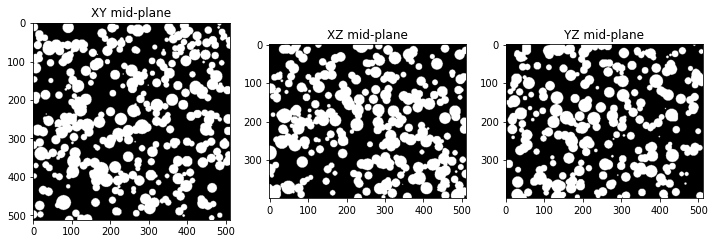

In [10]:
fig, ax = plt.subplots(1,3, figsize = (figw,figw/3))
h = viewer.view_midplanes(vol = Ph.vol, ax = ax)

### Synthetize Projections  

In [11]:
t0 = time.time()
projs = Ph.get_projections(theta = theta, beam = beam, \
                           noise = noise, \
                           detector_dist = detector_dist, \
                           blur_size = blur_size)
tot_time = (time.time() - t0)/60.0
print("Shape of the synthesized projections data: %s"%str(projs.shape))
print("Done in %.2f minutes"%tot_time)

Shape of the synthesized projections data: (501, 400, 512)
Done in 0.68 minutes


### View Projections  

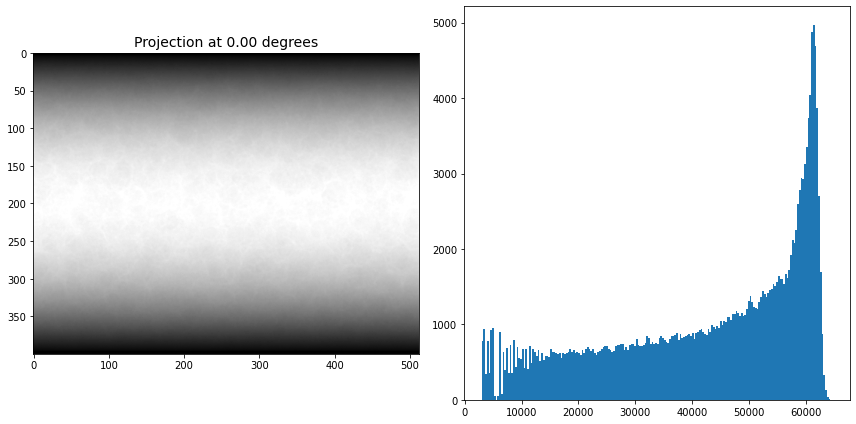

In [12]:
img_show = projs[0].copy()
img_show = np.clip(img_show, *modified_autocontrast(img_show, s = 0.01))
fig, ax = plt.subplots(1,2, figsize = (figw,figw/2))
h = ax[0].imshow(img_show, cmap = 'gray')
h = ax[0].set_title("Projection at %.2f degrees"%theta[0], fontsize = 14)
h = ax[1].hist(projs[0].reshape(-1), bins = 200)
# h = ax[1].imshow(projs[-1], cmap = 'gray')
# h = ax[1].set_title("Projection at %.2f degrees"%theta[1], fontsize = 14)
fig.tight_layout()

### View Sinograms  

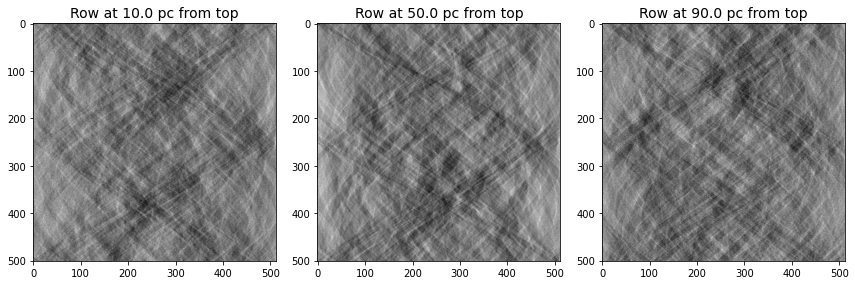

In [13]:
select_rows = [0.1,0.5,0.9]
select_idx = [int(select_row*projs.shape[1]) for select_row in select_rows]
fig, ax = plt.subplots(1,len(select_rows), figsize = (figw,figw/len(select_rows)))
for ii, idx in enumerate(select_idx):
    ax[ii].imshow(projs[:,idx,:], cmap = 'gray')
    ax[ii].set_title("Row at %.1f pc from top"%(100.0*select_rows[ii]), fontsize = 14)
fig.tight_layout()

### Do a test reconstruction with gridrec  

In [14]:
mask_ratio = 0.95
contrast_s = 0.01
rec = recon_wrapper(projs, beam, theta, pad_frac = 0.8, mask_ratio = mask_ratio, contrast_s = contrast_s)

Reconstructing 48 slice groups with 48 master threads...


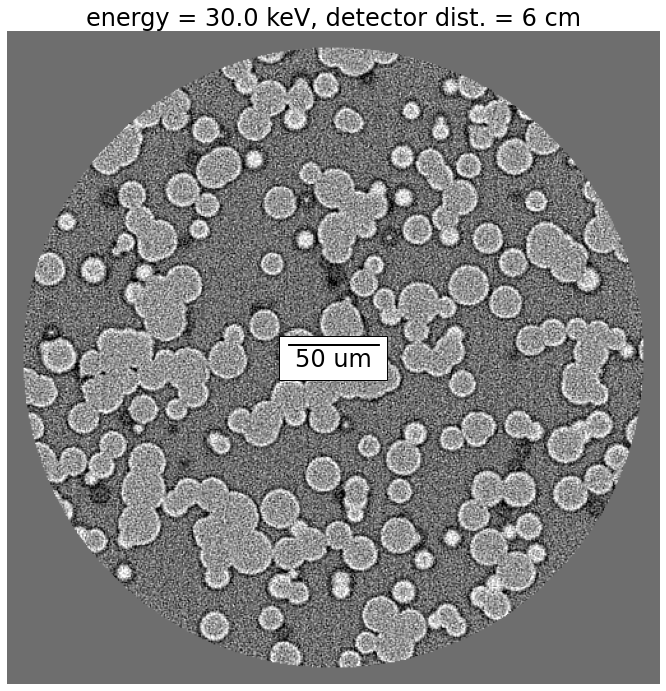

In [15]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
ax.imshow(rec[rec.shape[0]//2], cmap = 'gray')
ax.set_title("energy = %.1f keV, detector dist. = %.0f cm"%(energy_pts, detector_dist), fontsize = 24)
ax.axis('off')
viewer.add_scalebar(ax, 50, res, fontsize = 24, loc = 'center')

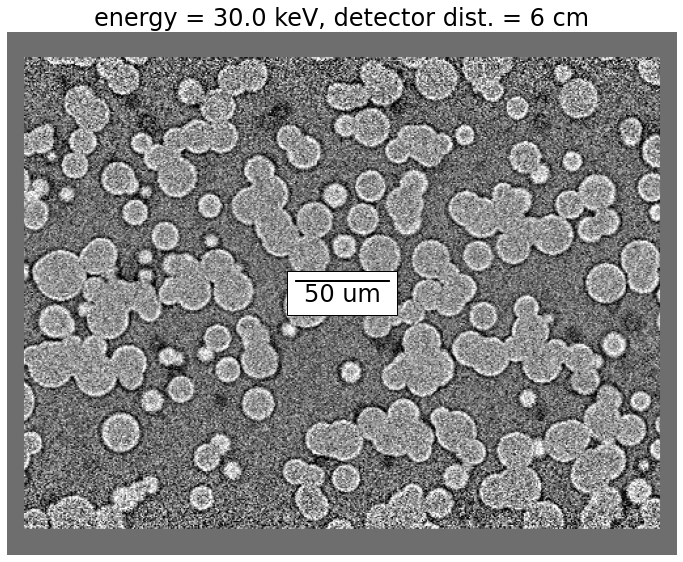

In [16]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
ax.imshow(rec[:,rec.shape[1]//2], cmap = 'gray')
ax.set_title("energy = %.1f keV, detector dist. = %.0f cm"%(energy_pts, detector_dist), fontsize = 24)
ax.axis('off')
viewer.add_scalebar(ax, 50, res, fontsize = 24, loc = 'center')

Text(0.5, 1.0, 'SNR = 1.57')

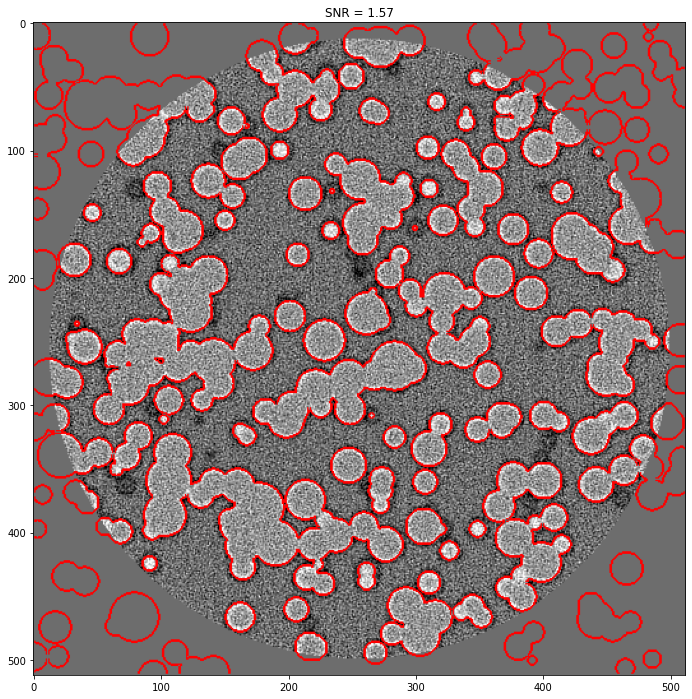

In [17]:
fig, ax = plt.subplots(1,1, figsize = (figw, figw))
idx_mid = int(rec.shape[0]//2)
viewer.edge_plot(rec[idx_mid], vol[idx_mid] > 0, ax = ax, color = [255,0,0])
ax.set_title("SNR = %.2f"%calc_SNR(rec[idx_mid], vol[idx_mid], labels = (0,1), mask_ratio = mask_ratio))

In [18]:
SNR_voids = calc_SNR(rec, vol, labels = (0,1), mask_ratio = mask_ratio)
print("SNR of material against voids: %.2f"%SNR_voids)

SNR of material against voids: 1.35


**Comments:** In this example, that there are two signal-noise ratios (SNR) to be evaluated: the contrast between the material and voids in background and the contrast between the inclusions against the material background. Depending on the attenuation properties of the materials, these may be very different.  

## Save Data Pairs  

We will save the following:  
1. Ground-truth labeled phantom (nz, ny, nx): Label 0 is void, label 1 is material, label 2 is inclusion material.  
2. Projection data: 16 bit data (n_projections, nrows, ncolumns).  
Note that ny = nx = ncolumns and nrows = nz.  
3. Test reconstruction: float (nz, ny, nx)  

Tips to save metadata:  
https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/  

In [19]:
import json

In [20]:
fname = "%s.hdf5"%sample_tag
fpath = os.path.join("../../../data_TomoTwin", fname)
hf = h5py.File(fpath, 'w')

In [21]:
# save exchange/data, exchange/data_bright and data_dark
g = hf.create_group("exchange")
d = g.create_dataset("data", data = projs, dtype = np.uint16)
d = g.create_dataset("data_bright", data = beam, dtype = np.uint16)
d = g.create_dataset("data_dark", data = np.zeros_like(beam), dtype = np.uint16)

In [22]:
# save exchange/measurement
gm = g.create_group("measurement")
gm.attrs["pixel_size"] = res
gm.attrs["energy"] = energy_pts
gm.attrs["detector_dist"] = detector_dist
gm.attrs["n_projections"] = n_projections
gm.attrs["noise_level"] = noise
gm.attrs["blur_kernel"] = blur_size

In [23]:
crop_slice, vcrop_slice = get_cropslices(vol.shape, mask_ratio)

# save phantom
g = hf.create_group("tomo")
d = g.create_dataset("gt_labels", \
                     data = vol[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
d = g.create_dataset("recon", \
                     data = rec[vcrop_slice, crop_slice, crop_slice], \
                     dtype = np.float32)
gm = g.create_group("phantom")
gm.attrs["sample_tag"] = sample_tag
m = gm.create_dataset("mat_dict", data = json.dumps(mat_dict))
m = gm.create_dataset("phantom_params", data = json.dumps(phantom_params))

In [24]:
time.ctime()

'Mon Jan 11 01:20:08 2021'

In [25]:
hf.close()

In [26]:
detector_dist

6.0